In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
import kaggler

In [30]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [31]:
data_dir = Path('./Dacon')
feature_dir = Path('./Dacon')
val_dir = Path('./Dacon')
tst_dir = Path('./Dacon')
sub_dir = Path('./Dacon')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [32]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [33]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(319820, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


In [34]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
# tst = df.iloc[320000:].values
tst = pd.read_csv(tst_file, index_col=0)
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)


(319820,) (319820, 18) (80000, 18)


In [35]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)


In [36]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.874425
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.766896
[3]	valid_0's multi_logloss: 0.686461
[4]	valid_0's multi_logloss: 0.629247
[5]	valid_0's multi_logloss: 0.568659
[6]	valid_0's multi_logloss: 0.523327
[7]	valid_0's multi_logloss: 0.482725
[8]	valid_0's multi_logloss: 0.448516
[9]	valid_0's multi_logloss: 0.416797
[10]	valid_0's multi_logloss: 0.3902
[11]	valid_0's multi_logloss: 0.371967
[12]	valid_0's multi_logloss: 0.357109
[13]	valid_0's multi_logloss: 0.33972
[14]	valid_0's multi_logloss: 0.322514
[15]	valid_0's multi_logloss: 0.307597
[16]	valid_0's multi_logloss: 0.295555
[17]	valid_0's multi_logloss: 0.28679
[18]	valid_0's multi_logloss: 0.277311
[19]	valid_0's multi_logloss: 0.267921
[20]	valid_0's multi_logloss: 0.26217
[21]	valid_0's multi_logloss: 0.258427
[22]	valid_0's multi_logloss: 0.252129
[23]	valid_0's multi_logloss: 0.245545
[24]	valid_0's multi_logloss: 0

[207]	valid_0's multi_logloss: 0.175697
[208]	valid_0's multi_logloss: 0.175681
[209]	valid_0's multi_logloss: 0.175716
[210]	valid_0's multi_logloss: 0.175714
[211]	valid_0's multi_logloss: 0.175735
[212]	valid_0's multi_logloss: 0.175691
[213]	valid_0's multi_logloss: 0.175633
[214]	valid_0's multi_logloss: 0.175525
[215]	valid_0's multi_logloss: 0.175464
[216]	valid_0's multi_logloss: 0.175482
[217]	valid_0's multi_logloss: 0.175519
[218]	valid_0's multi_logloss: 0.175516
[219]	valid_0's multi_logloss: 0.175452
[220]	valid_0's multi_logloss: 0.175433
[221]	valid_0's multi_logloss: 0.175388
[222]	valid_0's multi_logloss: 0.175385
[223]	valid_0's multi_logloss: 0.175426
[224]	valid_0's multi_logloss: 0.175441
[225]	valid_0's multi_logloss: 0.175402
[226]	valid_0's multi_logloss: 0.175393
[227]	valid_0's multi_logloss: 0.175388
[228]	valid_0's multi_logloss: 0.175396
[229]	valid_0's multi_logloss: 0.1754
[230]	valid_0's multi_logloss: 0.175403
[231]	valid_0's multi_logloss: 0.175381
[2

[47]	valid_0's multi_logloss: 0.193347
[48]	valid_0's multi_logloss: 0.192742
[49]	valid_0's multi_logloss: 0.19207
[50]	valid_0's multi_logloss: 0.191463
[51]	valid_0's multi_logloss: 0.19092
[52]	valid_0's multi_logloss: 0.190412
[53]	valid_0's multi_logloss: 0.19013
[54]	valid_0's multi_logloss: 0.189668
[55]	valid_0's multi_logloss: 0.189471
[56]	valid_0's multi_logloss: 0.189013
[57]	valid_0's multi_logloss: 0.188696
[58]	valid_0's multi_logloss: 0.188208
[59]	valid_0's multi_logloss: 0.187858
[60]	valid_0's multi_logloss: 0.187571
[61]	valid_0's multi_logloss: 0.187212
[62]	valid_0's multi_logloss: 0.186661
[63]	valid_0's multi_logloss: 0.186282
[64]	valid_0's multi_logloss: 0.186041
[65]	valid_0's multi_logloss: 0.185789
[66]	valid_0's multi_logloss: 0.185584
[67]	valid_0's multi_logloss: 0.18541
[68]	valid_0's multi_logloss: 0.185118
[69]	valid_0's multi_logloss: 0.184745
[70]	valid_0's multi_logloss: 0.184725
[71]	valid_0's multi_logloss: 0.184496
[72]	valid_0's multi_logloss:

[65]	valid_0's multi_logloss: 0.186457
[66]	valid_0's multi_logloss: 0.186207
[67]	valid_0's multi_logloss: 0.186
[68]	valid_0's multi_logloss: 0.185698
[69]	valid_0's multi_logloss: 0.185545
[70]	valid_0's multi_logloss: 0.185322
[71]	valid_0's multi_logloss: 0.18511
[72]	valid_0's multi_logloss: 0.184816
[73]	valid_0's multi_logloss: 0.184723
[74]	valid_0's multi_logloss: 0.184664
[75]	valid_0's multi_logloss: 0.184511
[76]	valid_0's multi_logloss: 0.184298
[77]	valid_0's multi_logloss: 0.184116
[78]	valid_0's multi_logloss: 0.18384
[79]	valid_0's multi_logloss: 0.184183
[80]	valid_0's multi_logloss: 0.184181
[81]	valid_0's multi_logloss: 0.183697
[82]	valid_0's multi_logloss: 0.183386
[83]	valid_0's multi_logloss: 0.183226
[84]	valid_0's multi_logloss: 0.183029
[85]	valid_0's multi_logloss: 0.182935
[86]	valid_0's multi_logloss: 0.182802
[87]	valid_0's multi_logloss: 0.182764
[88]	valid_0's multi_logloss: 0.182675
[89]	valid_0's multi_logloss: 0.182452
[90]	valid_0's multi_logloss: 

In [37]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')


92.4492%


In [38]:
print(p_val.shape, p_tst.shape)


(319820, 3) (80000, 3)


In [39]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

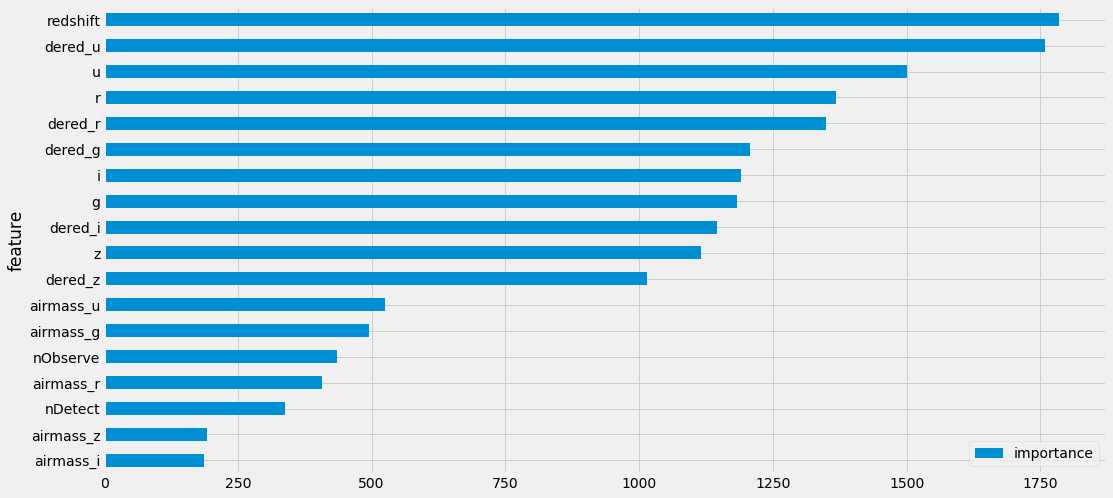

In [40]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [41]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [42]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [43]:
sub[target_col].value_counts()


2    41581
0    29974
1     8445
Name: class, dtype: int64

In [44]:
sub.to_csv(sub_file)
